# Projeto módulo 5 - Crédito para Financiamento de Imóveis


____________


## Contextualização

A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma fintech para desenvolver um projeto de concessão de crédito para imóveis. Nesse projeto, espera-se a criação de valor que **discrimine ao máximo** os **bons pagadores** dos **maus pagadores**. 

Para isso, foi disponibilizada uma base de dados com milhares de casos de **empréstimos do passado** com diversas características dos clientes. 

Entrega: um modelo com a **melhor performance** possível.

Métrica de performance (inicialmente proposta): **ROC-AUC.**

In [1]:
# importando bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from hyperopt import hp, tpe, fmin, Trials, space_eval
from sklearn.model_selection import cross_validate

import pickle

# ignorar avisos desnecessários para que a apresentação fique clean
import warnings
warnings.filterwarnings("ignore")

In [2]:
# funções utilizadas

def metrica_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    print("Coeficientes:\n", estimator.coef_)
    print("\nIntercept:", estimator.intercept_)

    # dê uma olhada nas classes do modelo
    classes =  estimator.classes_
    print("\nClasses:", classes)

    # 5) probabilidades das previsões
    probs = estimator.predict_proba(X_test)

    # probabilidade de pertencimento à classe 1
    probs_1 = probs[:, 1]
    
    #calculado a ROC
    fpr, tpr, thresholds = roc_curve(y_test, probs_1)
    plt.title("ROC curve")

    plt.plot(fpr, tpr)

    plt.xlabel("FPR")
    plt.ylabel("TPR")

    x = np.linspace(0, 1, 100)
    y = x
    plt.plot(x, y, ls=":", color="black")

    plt.show()
    
    RocCurveDisplay.from_predictions(y_test, probs_1)

    x = np.linspace(0, 1, 100)
    y = x
    plt.plot(x, y, ls=":", color="black")

    plt.show()
    
    roc_score = roc_auc_score(y_test, probs_1 )
    
    print("\nROC AUC SCORE:", roc_score)
    
def metrica_classificacao_pipe(estimator, X_train, X_test, y_train, y_test):
    
    # probabilidades das previsões
    probs = estimator.predict_proba(X_test)

    # probabilidade de pertencimento à classe 1
    probs_1 = probs[:, 1]
    
    #calculado a ROC
    fpr, tpr, thresholds = roc_curve(y_test, probs_1)
    plt.title("ROC curve")

    plt.plot(fpr, tpr)

    plt.xlabel("FPR")
    plt.ylabel("TPR")

    x = np.linspace(0, 1, 100)
    y = x
    plt.plot(x, y, ls=":", color="black")

    plt.show()
    
    RocCurveDisplay.from_predictions(y_test, probs_1)

    x = np.linspace(0, 1, 100)
    y = x
    plt.plot(x, y, ls=":", color="black")

    plt.show()
    
    roc_score = roc_auc_score(y_test, probs_1 )
    
    print("\nROC AUC SCORE:", roc_score)

    
def pipe_pre_process(df, drop_not_features=["TARGET"], col_target="TARGET",
                             inputer_num_strategy="mean",
                             encoding="onehot"):
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    '''
    

    X = df.drop(columns=drop_not_features)
    y = df[col_target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy=inputer_num_strategy)),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

In [3]:
# carregando o dataset

df = pd.read_csv("./dados/application_train.csv")

In [4]:
# visualização do dataset

df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


In [5]:
# visualização geral dos dados, temos: 65 variavéis numéricas contínuas,
# 41 variáveis numéricas discretas e 16 variáveis categóricas

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 229.0+ MB


In [6]:
# consultando o tamanho da base

df.shape

(246008, 122)

In [7]:
# visualização das colunas disponíveis e o número total de colunas

df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [8]:
# visualização das estatísticas gerais

df.describe().apply(lambda x: round(x, 1))

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,246008.0,246008.0,246008.0,246008.0,246008.0,245998.0,245782.0,246008.0,246008.0,246008.0,...,246008.0,246008.0,246008.0,246008.0,212836.0,212836.0,212836.0,212836.0,212836.0,212836.0
mean,278280.1,0.1,0.4,168912.2,599628.3,27129.2,538928.9,0.0,-16042.8,63963.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3,1.9
std,102790.9,0.3,0.7,260381.8,403067.2,14505.0,369973.8,0.0,4366.0,141400.3,...,0.1,0.0,0.0,0.0,0.1,0.1,0.2,0.9,0.6,1.9
min,100002.0,0.0,0.0,25650.0,45000.0,1615.5,40500.0,0.0,-25229.0,-17912.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,189165.5,0.0,0.0,112500.0,270000.0,16561.1,238500.0,0.0,-19691.0,-2758.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,278392.5,0.0,0.0,148500.0,514777.5,24930.0,450000.0,0.0,-15763.0,-1215.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
75%,367272.2,0.0,1.0,202500.0,808650.0,34599.4,679500.0,0.0,-12418.0,-289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
max,456255.0,1.0,19.0,117000000.0,4050000.0,258025.5,4050000.0,0.1,-7489.0,365243.0,...,1.0,1.0,1.0,1.0,4.0,9.0,8.0,27.0,19.0,23.0


In [9]:
# dataframe apenas com features categóricas

df.select_dtypes(include=np.number)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,0,112500.0,700830.0,22738.5,585000.0,0.019689,-8676,-813,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,0,90000.0,375322.5,14422.5,324000.0,0.025164,-13583,-223,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,0,180000.0,544491.0,16047.0,454500.0,0.035792,-13993,-6202,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,0,270000.0,814041.0,28971.0,679500.0,0.046220,-22425,365243,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,0,144000.0,675000.0,21906.0,675000.0,0.026392,-18839,-2763,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,242114,0,1,270000.0,1172470.5,34411.5,918000.0,0.035792,-15992,-4333,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,8.0
246004,452374,0,0,180000.0,654498.0,27859.5,585000.0,0.003122,-23798,365243,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
246005,276545,1,1,112500.0,270000.0,13500.0,270000.0,0.011657,-14793,-1982,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
246006,236776,1,3,202500.0,204858.0,17653.5,171000.0,0.016612,-14418,-2840,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# dataframe apenas com features numéricas

df.select_dtypes(exclude=np.number)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,F,N,N,Unaccompanied,Working,Incomplete higher,Single / not married,House / apartment,Core staff,FRIDAY,Trade: type 2,reg oper account,block of flats,Block,No
1,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,High skill tech staff,MONDAY,Business Entity Type 3,reg oper account,block of flats,Block,No
2,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Managers,THURSDAY,Business Entity Type 1,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,TUESDAY,XNA,NaN,NaN,NaN,No
4,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,Laborers,FRIDAY,Transport: type 4,reg oper account,block of flats,Panel,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Sales staff,FRIDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
246004,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,NaN,SATURDAY,XNA,reg oper spec account,block of flats,Block,No
246005,Revolving loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,SATURDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
246006,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,With parents,Laborers,SUNDAY,Self-employed,NaN,NaN,NaN,NaN


In [11]:
# visualizar as colunas com dados nulos

df.isna().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     33172
AMT_REQ_CREDIT_BUREAU_WEEK    33172
AMT_REQ_CREDIT_BUREAU_MON     33172
AMT_REQ_CREDIT_BUREAU_QRT     33172
AMT_REQ_CREDIT_BUREAU_YEAR    33172
Length: 122, dtype: int64

### Análises inicias

In [12]:
# consultando a feature TARGET onde 0 = bons pagadores e 1 = maus pagadores

df["TARGET"].value_counts()

0    226038
1     19970
Name: TARGET, dtype: int64

In [13]:
# utilizando o %

df["TARGET"].value_counts(normalize=True)

0    0.918824
1    0.081176
Name: TARGET, dtype: float64

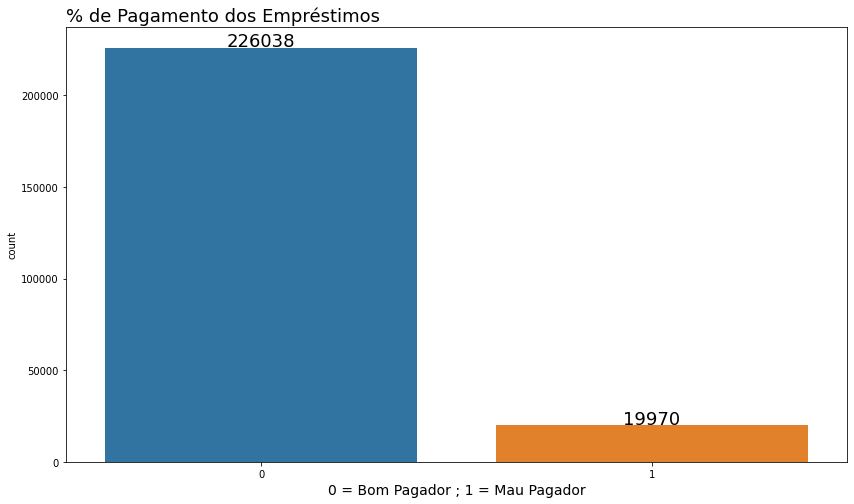

In [14]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(x=df.TARGET)

for i in ax.patches:
    ax.annotate(i.get_height(),
                  (i.get_x() + i.get_width() / 2, i.get_height()),
                  ha="center",
                  va="baseline",
                  fontsize=18,
                  color="black",
                  xytext=(0, 1),
                  textcoords="offset points")
    
plt.title("% de Pagamento dos Empréstimos", loc="left", fontsize=18)
plt.xlabel("0 = Bom Pagador ; 1 = Mau Pagador", fontsize=14);

### O Target é formado por 91,89% de bons pagadores

In [15]:
# idade dos clientes

(df["DAYS_BIRTH"]/-365).describe().apply(lambda x: round(x, 1))

count    246008.0
mean         44.0
std          12.0
min          20.5
25%          34.0
50%          43.2
75%          53.9
max          69.1
Name: DAYS_BIRTH, dtype: float64

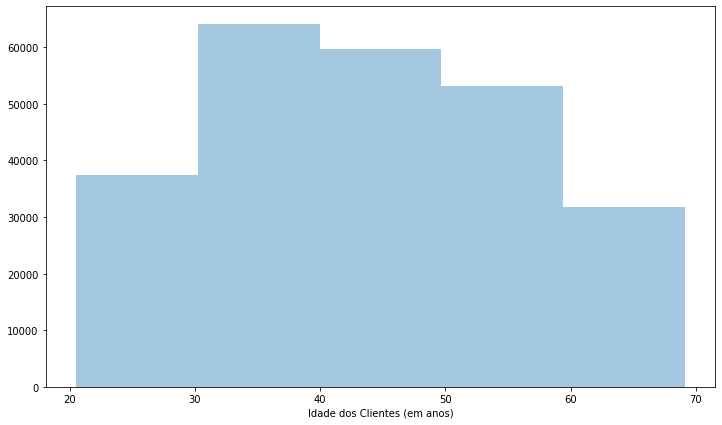

In [16]:
fig, ax = plt.subplots(figsize =(12,7))
sns.distplot(df["DAYS_BIRTH"]/-365,bins=5,kde=False)
plt.xlabel("Idade dos Clientes (em anos)");

In [17]:
# visualizando os tipos de empréstimos

df["NAME_CONTRACT_TYPE"].unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [18]:
# % de empréstimos de cada tipo que tiveram problemas com o pagamento (1)

for item in list(df["NAME_CONTRACT_TYPE"].unique()):
    print(f"Tipo de empréstimo: {item}\n")
    print(df[(df["NAME_CONTRACT_TYPE"] == str(item))]["TARGET"].value_counts(normalize=True))
    print("#"*80)
    print()

Tipo de empréstimo: Cash loans

0    0.916068
1    0.083932
Name: TARGET, dtype: float64
################################################################################

Tipo de empréstimo: Revolving loans

0    0.945053
1    0.054947
Name: TARGET, dtype: float64
################################################################################



In [19]:
# visualizando os níveis educacionais

df["NAME_EDUCATION_TYPE"].unique()

array(['Incomplete higher', 'Secondary / secondary special',
       'Higher education', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [20]:
# % de empréstimos por nível educacional que tiveram problemas com o pagamento (1)

for item in list(df["NAME_EDUCATION_TYPE"].unique()):
    print(f"Nível educacional: {item}\n")
    print(df[(df["NAME_EDUCATION_TYPE"] == str(item))]["TARGET"].value_counts(normalize=True))
    print("#"*80)
    print()

Nível educacional: Incomplete higher

0    0.912768
1    0.087232
Name: TARGET, dtype: float64
################################################################################

Nível educacional: Secondary / secondary special

0    0.910193
1    0.089807
Name: TARGET, dtype: float64
################################################################################

Nível educacional: Higher education

0    0.9463
1    0.0537
Name: TARGET, dtype: float64
################################################################################

Nível educacional: Lower secondary

0    0.887816
1    0.112184
Name: TARGET, dtype: float64
################################################################################

Nível educacional: Academic degree

0    0.977444
1    0.022556
Name: TARGET, dtype: float64
################################################################################



In [21]:
# análise das faixas de renda

df["AMT_INCOME_TOTAL"].describe().apply(lambda x: round(x, 1))

count       246008.0
mean        168912.2
std         260381.8
min          25650.0
25%         112500.0
50%         148500.0
75%         202500.0
max      117000000.0
Name: AMT_INCOME_TOTAL, dtype: float64

In [22]:
# é possível verificar a presença de outliers, algumas rendas muito acima das demais

df["AMT_INCOME_TOTAL"].sort_values()

175747        25650.0
139351        26100.0
181585        26100.0
4411          26550.0
131967        27000.0
             ...     
139830      6750000.0
169895      9000000.0
115995     13500000.0
35452      18000090.0
159421    117000000.0
Name: AMT_INCOME_TOTAL, Length: 246008, dtype: float64

In [23]:
# divisão das rendas em "faixas de rendas" com os valores determinados nas análises de mínimo,
# máximo e concentrações por quartis

bins = [10000, 50000, 150000, 250000, 500000, 1000000, 117000000]
df["INCOME_RANGE"] = pd.cut(df["AMT_INCOME_TOTAL"], bins = bins)

df["INCOME_RANGE"]

0          (50000, 150000]
1          (50000, 150000]
2         (150000, 250000]
3         (250000, 500000]
4          (50000, 150000]
                ...       
246003    (250000, 500000]
246004    (150000, 250000]
246005     (50000, 150000]
246006    (150000, 250000]
246007     (50000, 150000]
Name: INCOME_RANGE, Length: 246008, dtype: category
Categories (6, interval[int64, right]): [(10000, 50000] < (50000, 150000] < (150000, 250000] < (250000, 500000] < (500000, 1000000] < (1000000, 117000000]]

In [24]:
# % de empréstimos por faixa de renda que tiveram problemas com o pagamento (1)

for item in list(df["INCOME_RANGE"].unique()):
    print(f"Faixa de renda: {item}\n")
    print(df[(df["INCOME_RANGE"] == item)]["TARGET"].value_counts(normalize=True))
    print("#"*80)
    print()

Faixa de renda: (50000, 150000]

0    0.914814
1    0.085186
Name: TARGET, dtype: float64
################################################################################

Faixa de renda: (150000, 250000]

0    0.918226
1    0.081774
Name: TARGET, dtype: float64
################################################################################

Faixa de renda: (250000, 500000]

0    0.934398
1    0.065602
Name: TARGET, dtype: float64
################################################################################

Faixa de renda: (10000, 50000]

0    0.924263
1    0.075737
Name: TARGET, dtype: float64
################################################################################

Faixa de renda: (500000, 1000000]

0    0.943878
1    0.056122
Name: TARGET, dtype: float64
################################################################################

Faixa de renda: (1000000, 117000000]

0    0.95
1    0.05
Name: TARGET, dtype: float64
##################################################

In [25]:
# verificação das ocupações

df["OCCUPATION_TYPE"].unique()

array(['Core staff', 'High skill tech staff', 'Managers', nan, 'Laborers',
       'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff',
       'Accountants', 'Low-skill Laborers', 'Security staff',
       'Realty agents', 'Private service staff', 'Medicine staff',
       'Secretaries', 'HR staff', 'Waiters/barmen staff', 'IT staff'],
      dtype=object)

In [26]:
# % de empréstimos por Ocupação que tiveram problemas com o pagamento (1).

for item in list(df["OCCUPATION_TYPE"].unique()):
    print(f"Ocupação: {item}\n")
    print(df[(df["OCCUPATION_TYPE"] == item)]["TARGET"].value_counts(normalize=True))
    print("#"*80)
    print()

Ocupação: Core staff

0    0.936345
1    0.063655
Name: TARGET, dtype: float64
################################################################################

Ocupação: High skill tech staff

0    0.939813
1    0.060187
Name: TARGET, dtype: float64
################################################################################

Ocupação: Managers

0    0.937768
1    0.062232
Name: TARGET, dtype: float64
################################################################################

Ocupação: nan

Series([], Name: TARGET, dtype: float64)
################################################################################

Ocupação: Laborers

0    0.893645
1    0.106355
Name: TARGET, dtype: float64
################################################################################

Ocupação: Drivers

0    0.886195
1    0.113805
Name: TARGET, dtype: float64
################################################################################

Ocupação: Sales staff

0    0.903192
1    0.096808
Na

### Modelo Baseline Inicial

- Descartar NaNs, dados nulos e categóricos
- Treinar classificadores simples

In [27]:
df_model_baseline = df.select_dtypes(include=np.number).dropna(axis=1)

X = df_model_baseline.drop(columns="TARGET")
y = df_model_baseline["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

dados_split = (X_train, X_test, y_train, y_test)

### Regressão Linear

Coeficientes:
 [[-9.40242412e-07 -3.21427807e-08 -1.51939195e-06 -1.85682186e-07
  -1.28290114e-09  9.18758432e-05  6.47179998e-07  2.80697126e-05
   9.89810991e-05 -2.56450180e-08 -2.51505801e-08  2.75056123e-09
  -2.55032823e-08 -2.37019183e-08 -5.64570159e-09  6.66125954e-10
   1.90289435e-09 -5.09622790e-07 -3.42561217e-10 -1.50202693e-10
  -1.88328002e-10  1.05771690e-08  1.45273203e-08  8.64902451e-09
   7.56747546e-11  1.86906039e-08 -6.69008638e-11 -8.62467326e-10
   2.61730515e-09 -4.83641697e-11 -8.38346733e-09 -4.36028883e-10
  -1.70443403e-11 -1.43077145e-09  0.00000000e+00 -1.50548108e-09
  -1.13427404e-09 -4.50320017e-10 -2.84353682e-09 -1.04596105e-10
  -2.80723336e-09 -1.87850195e-10 -1.15293614e-11 -7.95019417e-11]]

Intercept: [-2.56548168e-08]

Classes: [0 1]


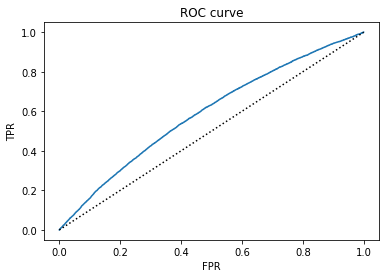

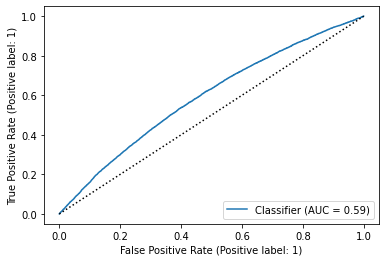


ROC AUC SCORE: 0.5913686995043024


In [28]:
lr_baseline = LogisticRegression().fit(X_train, y_train)

metrica_classificacao(lr_baseline, *dados_split)

In [29]:
# salvando o Modelo de Linear Regression

with open("lr_baseline.pkl", "wb") as f:
    
    pickle.dump(lr_baseline, f)

In [30]:
with open("lr_baseline.pkl", "rb") as f:
    
    model_lr_baseline = pickle.load(f)

In [31]:
model_lr_baseline

LogisticRegression()

### Gradient Boosting e Random Forest

In [48]:
# Pré-processamento das Features

X_train, X_test, y_train, y_test, pre_processador = pipe_pre_process(df)




             Pipe: Gradient boosting              



[Pipeline] ... (step 1 of 2) Processing pre_processador, total=   5.7s
      Iter       Train Loss   Remaining Time 
         1           0.5548           12.14m
         2           0.5486           12.02m
         3           0.5436           11.76m
         4           0.5397           11.99m
         5           0.5363           11.94m
         6           0.5335           11.70m
         7           0.5310           11.72m
         8           0.5289           11.44m
         9           0.5271           11.26m
        10           0.5252           11.05m
        11           0.5240           10.90m
        12           0.5224           10.75m
        13           0.5210           10.58m
        14           0.5200           10.44m
        15           0.5189           10.35m
        16           0.5176           10.18m
        17           0.5165            9.99m
        18           0.5156            9.82m
        19      

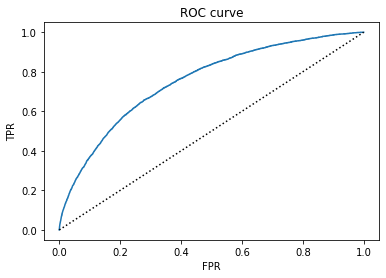

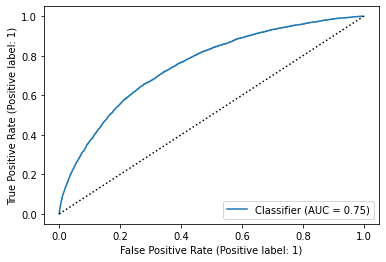


ROC AUC SCORE: 0.7532097119311953



               Pipe: Random forest                



[Pipeline] ... (step 1 of 2) Processing pre_processador, total=   5.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.6s remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s


building tree 5 of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.1s remaining:    0.0s


building tree 6 of 100


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    9.8s remaining:    0.0s


building tree 7 of 100


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   11.9s remaining:    0.0s


building tree 8 of 100


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   14.0s remaining:    0.0s


building tree 9 of 100


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   15.8s remaining:    0.0s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished


[Pipeline] ................ (step 2 of 2) Processing rf, total= 3.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished


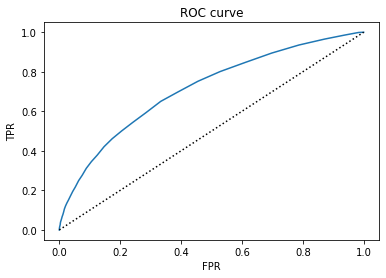

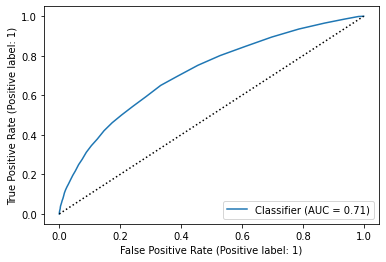


ROC AUC SCORE: 0.7129746806770055


In [49]:
# Pipelines para identificar possíveis melhores estimadores e verificar a performance com os hiperparâmetros default

pipe_gb = Pipeline([("pre_processador", pre_processador),
                     ("gb", GradientBoostingClassifier(random_state=42, verbose = 10))], verbose = 10)

pipe_rf = Pipeline([("pre_processador", pre_processador),
                     ("rf", RandomForestClassifier(random_state=42, verbose = 10))], verbose = 10)

# ==================

pipes_dict = {"Gradient boosting": pipe_gb, "Random forest": pipe_rf}

for label, pipe in pipes_dict.items():
    
    print("\n\n")
    print("="*50)
    print(f"Pipe: {label}".center(50))
    print("="*50)
    print("\n\n")
    
    pipe.fit(X_train, y_train)

    ########################################

    dados_split = (X_train, X_test, y_train, y_test)

    metrica_classificacao_pipe(pipe, *dados_split)

In [50]:
# salvando o Modelo de Gradient Boosting

with open("pipe_gb.pkl", "wb") as f:
    
    pickle.dump(pipe_gb, f)

In [51]:
with open("pipe_gb.pkl", "rb") as f:
    
    model_pipe_gb = pickle.load(f)

In [52]:
model_pipe_gb

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_

In [53]:
# salvando o Modelo de Random Forest

with open("pipe_rf.pkl", "wb") as f:
    
    pickle.dump(pipe_rf, f)

In [54]:
with open("pipe_rf.pkl", "rb") as f:
    
    model_pipe_rf = pickle.load(f)

In [55]:
model_pipe_rf

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_

### Otimização Bayesiana

In [36]:
def pipe_pre_home_credit(drop_not_features=["TARGET"], col_target="TARGET",
                             inputer_num_strategy="mean",
                             encoding="ordinal"):
    '''
    - inputer_num_strategy (str): "mean", "median";
    - encoding (str): "onehot" para OneHotEncoder; "ordinal" OrdinalEncoder;
    '''
    
    X = df.drop(columns=drop_not_features)
    y = df[col_target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

    # ==========================================================

    pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy=inputer_num_strategy)),
                                  ("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()

    # ==========================================================

    if encoding == "onehot":
    
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("onehot", OneHotEncoder(handle_unknown="ignore"))])
        
    elif encoding == "ordinal":
        
        pipe_features_cat = Pipeline([("input_cat", SimpleImputer(strategy="constant", fill_value="unknown")),
                                      ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value",
                                                                 unknown_value=-1))])
    
    else:
        
        raise ValueError("Únicos encodings disponíveis são 'ordinal' e 'onehot'")
        
        
    features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                         ("transf_cat", pipe_features_cat, features_cat)])

    return X_train, X_test, y_train, y_test, pre_processador

In [37]:
# construindo um modelo com os hiperparâmetros default

X_train, X_test, y_train, y_test, pre_processador = pipe_pre_home_credit(drop_not_features=["TARGET"], 
                                                                            col_target="TARGET",
                                                                            inputer_num_strategy="mean",
                                                                            encoding="ordinal")

In [38]:
pre_processador

ColumnTransformer(transformers=[('transf_num',
                                 Pipeline(steps=[('input_num', SimpleImputer()),
                                                 ('std', StandardScaler())]),
                                 ['SK_ID_CURR', 'CNT_CHILDREN',
                                  'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
                                  'FLAG_MOBIL', 'FLAG_EMP_PHONE...
                                                                 unknown_value=-1))]),
                                 ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                  'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                  'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
         

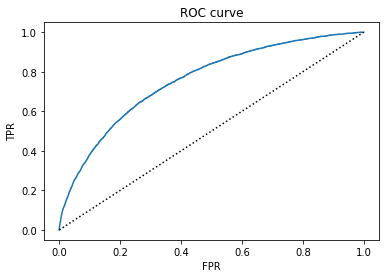

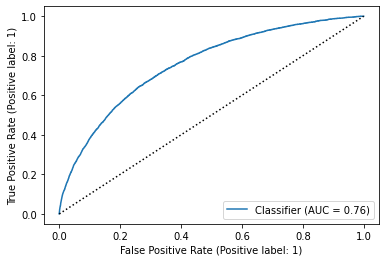


ROC AUC SCORE: 0.757140956634917


In [60]:
pipe_ob = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(random_state=42))])

pipe_ob.fit(X_train, y_train)

metrica_classificacao_pipe(pipe_ob, *dados_split)

In [68]:
# salvando o Modelo de Otimozação Bayesiana com os hiperparâmetros default

with open("pipe_ob.pkl", "wb") as f:
    
    pickle.dump(pipe_ob, f)

In [69]:
with open("pipe_ob.pkl", "rb") as f:
    
    model_ob = pickle.load(f)

In [70]:
model_ob

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION'

In [55]:
# tentativa de melhorar utilizando o Grid Search Gradient Boosting

pipe = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(random_state=42))])

params_grid = {"gb__loss" : ["deviance", "exponential"],
               "gb__n_estimators" : np.arange(1, 6)*100,
               "gb__max_depth" : [1, 2]}

splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

grid_gb = GridSearchCV(pipe,
                       params_grid, 
                       cv=splitter,
                       scoring="roc_auc",
                       verbose=10,
                       n_jobs=-1)

grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['SK_ID_CURR',
                                                                          'CNT_CHILDREN',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
            

In [57]:
grid_gb.best_params_

{'gb__loss': 'deviance', 'gb__max_depth': 2, 'gb__n_estimators': 500}

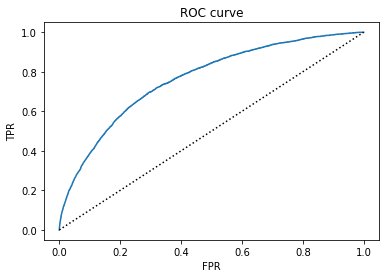

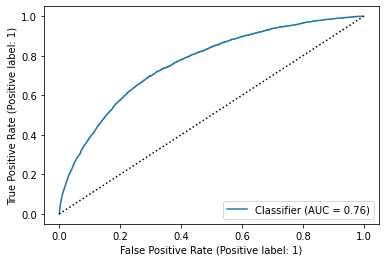


ROC AUC SCORE: 0.7636026571267271


In [58]:
# melhor resultado, com o Grid Search Gradient Boosting

metrica_classificacao_pipe(grid_gb, *dados_split)

In [131]:
# salvando o Modelo de Grid Search Gradient Boosting, melhor resultado obtido

with open("grid_gb.pkl", "wb") as f:
    
    pickle.dump(grid_gb, f)

In [132]:
with open("grid_gb.pkl", "rb") as f:
    
    model_grid_gb = pickle.load(f)

In [133]:
model_grid_gb

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['SK_ID_CURR',
                                                                          'CNT_CHILDREN',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
            

In [39]:
# tentativa de melhora com a Otimização Bayesiana, definindo o espaço de parâmetros

hps_space = {"loss" : hp.choice("loss", ["deviance", "exponential"]),
             "n_estimators" : hp.choice("n_estimators", range(1, 501)),
             "max_depth" : hp.choice("max_depth", [1, 2])}

In [40]:
# definindo a função objetivo

def objective(hps_space):
    
    pipe = Pipeline([("pp", pre_processador),
                     ("gb", GradientBoostingClassifier(**hps_space))])

    # =============================================

    splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    results = cross_validate(pipe,
                             X_train, y_train, 
                             cv=splitter,
                             scoring="roc_auc",
                             n_jobs=-1)

    mean_roc = results["test_score"].mean()

    # como o valor vai ser minimizado, mas queremos MAXIMIZAR o f1, colocamos esse sinal negativo
    return -mean_roc

In [41]:
# instanciando a classe Trials()

trials = Trials()

best_hps = fmin(objective,
                space=hps_space,
                algo=tpe.suggest,
                trials=trials,
                rstate=np.random.default_rng(42),
                max_evals=10)

100%|███████████████████████████████████████████| 10/10 [3:01:28<00:00, 1088.84s/trial, best loss: -0.7543678780792901]


In [42]:
# pré-resposta da otimização

best_hps

{'loss': 0, 'max_depth': 1, 'n_estimators': 374}

In [43]:
# transformando os hiperparâmetros para o espaço correto
# a resposta final, vem com o space_eval

best_hps = space_eval(hps_space, best_hps)

In [44]:
best_hps

{'loss': 'deviance', 'max_depth': 2, 'n_estimators': 375}

In [ ]:
best_hps.best_params_

In [ ]:
GradientBoostingClassifier(**best_hps)

In [ ]:
pipe_hps = Pipeline([("pp", pre_processador),
                 ("gb", GradientBoostingClassifier(**best_hps))])

pipe_hps.fit(X_train, y_train)

metrica_classificacao_pipe(pipe_hps, *dados_split)

In [ ]:
# salvando o Modelo de Grid Search Gradient Boosting com definição do espaço de parâmetros

with open("pipe_hps.pkl", "wb") as f:
    
    pickle.dump(pipe_hps, f)

In [ ]:
with open("pipe_hps.pkl", "rb") as f:
    
    model_grid_gb_hps = pickle.load(f)

In [ ]:
model_grid_gb_hps

## Modelos Treinados

In [ ]:
# Modelo de Regressão Linear

model_lr_baseline

In [65]:
# Modelo de Gradient Boosting

model_pipe_gb

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_

In [66]:
# Modelo de Random Forest

model_pipe_rf

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_

In [67]:
# Modelo de Otimização Bayesiana

model_ob

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('input_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   StandardScaler())]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION'

In [156]:
# Modelo de Grid Search Gradient Boosting, melhor resultado obtido

model_grid_gb

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['SK_ID_CURR',
                                                                          'CNT_CHILDREN',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
            

In [ ]:
# Modelo de Grid Search Gradient Boosting com definição o espaço de parâmetros
# (trocar o nome da variável pipe, rodar novamente e salvar o modelo com outro nome)

model_grid_gb_hps

### BASE DE TESTE

In [161]:
# carregando o dataset de treino

df_teste = pd.read_csv("./dados/application_test_student.csv")

In [162]:
# visualização do dataset de treino

df_teste.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,149741,Cash loans,F,N,N,0,117000.0,417024.0,20191.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,363290,Cash loans,M,N,Y,0,450000.0,640080.0,31261.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,436006,Revolving loans,M,Y,Y,0,450000.0,900000.0,45000.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
3,377703,Cash loans,M,Y,N,1,360000.0,1125000.0,33025.5,1125000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,188624,Cash loans,M,Y,Y,0,675000.0,835380.0,42840.0,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [163]:
# é possível verificar a presença de outliers, algumas rendas muito acima das demais

df_teste["AMT_INCOME_TOTAL"].sort_values()

61160      25650.0
12612      26100.0
27199      26460.0
11172      26550.0
50154      27000.0
           ...    
43925    2250000.0
11800    2930026.5
24230    3150000.0
13678    3600000.0
12476    3825000.0
Name: AMT_INCOME_TOTAL, Length: 61503, dtype: float64

In [164]:
# divisão das rendas em "faixas de rendas" com os valores determinados nas análises de mínimo,
# máximo e concentrações por quartis

bins = [10000, 50000, 150000, 250000, 500000, 1000000, 117000000]
df_teste["INCOME_RANGE"] = pd.cut(df_teste["AMT_INCOME_TOTAL"], bins = bins)

df_teste["INCOME_RANGE"]

0          (50000, 150000]
1         (250000, 500000]
2         (250000, 500000]
3         (250000, 500000]
4        (500000, 1000000]
               ...        
61498     (150000, 250000]
61499      (50000, 150000]
61500     (150000, 250000]
61501     (150000, 250000]
61502      (50000, 150000]
Name: INCOME_RANGE, Length: 61503, dtype: category
Categories (6, interval[int64, right]): [(10000, 50000] < (50000, 150000] < (150000, 250000] < (250000, 500000] < (500000, 1000000] < (1000000, 117000000]]

In [171]:
# carregando o modelo

with open("grid_gb.pkl", "rb") as f:
    
    model_grid_gb = pickle.load(f)

In [172]:
# predição onde 0 = bons pagadores e 1 = maus pagadores

predictions = model_grid_gb.predict(df_teste)
target = pd.Series(predictions)

In [173]:
proba_1 = model_grid_gb.predict_proba(df_teste)[:, 1]
proba_percent = (model_grid_gb.predict_proba(df_teste)[:, 1]*100)

In [174]:
aux = {"SK_ID_CURR" : df_teste["SK_ID_CURR"], "PROBABILITY_VALUE_1": proba_1}

df_entrega = pd.DataFrame(aux)
df_entrega.head()

,SK_ID_CURR,PROBABILITY_VALUE_1
0,149741,0.305031
1,363290,0.042836
2,436006,0.060978
3,377703,0.047718
4,188624,0.308828


In [175]:
# salvando em arquivo csv

df_entrega.to_csv("projeto-pedro-bastos-santana.csv")